In [1]:
import pylandstats as pls
import os,glob,time
import numpy as np
from tqdm.auto import tqdm
import rasterio as rio
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
from xrspatial.classify import reclassify
import matplotlib.pyplot as plt
import time
%matplotlib inline

print(os.getcwd())
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim1/'

proj = 'EPSG:32613'  # WGS 83 / UTM Zone 13N

# SRME boundary
srme = os.path.join(maindir,'data/spatial/mod/boundaries/us_eco_l3_srme_nad83.gpkg')
# White River boundary
wrnf = os.path.join(maindir,'data/case-study/wrnf_boundary.gpkg')

rois = [srme,wrnf]

# "Test" data

# Load the classification raster (10-meter)
aspen10m_path = os.path.join(maindir,'data/spatial/mod/results/classification/aspen_prob_10m_binOpt.tif')  
# aspen10m_path_wrnf = os.path.join(maindir,'data/spatial/mod/results/classification/aspen_prob_10m_binOpt_wrnf.tif')  

# Load the classification raster (30-meter)
aspen30m_path = os.path.join(maindir,'data/spatial/mod/results/classification/aspen_prob_10m_binOpt_max30m.tif')  

test_paths = [aspen10m_path, aspen30m_path]

# "Reference" data

# Load the LANDFIRE c. 2016 EVT (for the SRME)
evt30m_path = os.path.join(maindir,'data/spatial/mod/landfire/lc16_evt_srme_aspen_r01_utm.tif')  
itsp_path = os.path.join(maindir,'data/spatial/mod/USFS/itsp_aspen_srme_r1_.tif')
treemap_path = os.path.join(maindir,'data/spatial/mod/USFS/treemap16_spcd_746_int.tif')

ref_paths = [treemap_path, evt30m_path, itsp_path]

print("Success ...")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim1/code/Python
Success ...


In [2]:
def compute_ls_metrics(ls_list,rois,source,class_code=1):
    patch_stats=[]
    class_stats = []
    regions = ['SRME','WRNF']
    
    start_time = time.time()

    for i in range(len(rois)):
        
        ls_ = ls_list[i]
        
        region = regions[i]
        print(f"Computing patch metrics from '{source}' for the {region} landscape ...")

        # Compute the aspen patch metrics 

        area = pd.DataFrame(ls_.area(class_val=class_code, hectares=True)).reset_index()  # patch area
        print(area.head())
        print(area.max())

        perimeter = pd.DataFrame(ls_.perimeter(class_val=class_code) ).reset_index() # perimeter length    
        perimeter_ar_r = pd.DataFrame(ls_.perimeter_area_ratio(class_val=class_code, hectares=True)).reset_index()
        shp_i = pd.DataFrame(ls_.shape_index(class_val=class_code)).reset_index()

        patch_df = pd.merge(area, perimeter, on="index")
        patch_df = pd.merge(patch_df, perimeter_ar_r, on="index")
        patch_df = pd.merge(patch_df, shp_i, on="index")
        patch_df['region'] = region
        patch_df['source'] = source
        print(patch_df.head())

        patch_stats.append(patch_df)

        # patch_df.to_csv(os.path.join(maindir,f'data/tabular/mod/results/ls_metrics/{region}_{source}_patch_metrics.csv'))
        print("Successfully exported patch metrics table!")

        # Class and landscape-level metrics

        print("Computing class-level metrics ...")

        tot_ar = ls_.total_area(class_val=class_code, hectares=True)
        prop = ls_.proportion_of_landscape(class_val=class_code, percent=True)
        n_ptchs = ls_.number_of_patches(class_val=class_code)
        ptch_den = ls_.patch_density(class_val=class_code, percent=True, hectares=True)

        class_df = pd.DataFrame(
            {'total_area': [tot_ar],
             'prop_area': [prop],
             'n_patch': [n_ptchs],
             'patch_den': [ptch_den]
            }
        )
        class_df['region'] = region
        class_df['source'] = source
        
        print(class_df)

        class_stats.append(class_df)

        # class_df.to_csv(os.path.join(maindir,f'data/tabular/mod/results/ls_metrics/{region}_{source}_class_metrics.csv'))
        print("Successfully exported class metrics table!")
        del area, perimeter, perimeter_ar_r, shp_i, patch_df, tot_ar, prop, n_ptchs, ptch_den, class_df
    
    # Concatenate the metrics
    class_metrics = pd.concat(class_stats, axis=0)
    patch_metrics = pd.concat(patch_stats, axis=0)

    class_metrics.to_csv(os.path.join(maindir,f'data/tabular/mod/results/ls_metrics/{source}_class_metrics.csv'))
    patch_metrics.to_csv(os.path.join(maindir,f'data/tabular/mod/results/ls_metrics/{source}_patch_metrics.csv'))
    
    class_metrics = []
    patch_metrics = []

    print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# Compute Patch-Level Metrics
### For the SRME and the White River NF and reference images

Starting for treemap16_spcd_746_int.tif
NoData value: None
Starting for us_eco_l3_srme_nad83.gpkg ...
CRS matches!
Clipping
[0 1]
Generating Landscape
Starting for wrnf_boundary.gpkg ...
CRS matches!
Clipping
[0 1]
Generating Landscape
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Computing patch metrics from 'treemap16_spcd_746_int' for the SRME landscape ...
   index  area
0      0  0.09
1      1  0.09
2      2  0.09
3      3  0.63
4      4  0.09
index    1304781.00
area       54813.15
dtype: float64
   index  area  perimeter  perimeter_area_ratio  shape_index region  \
0      0  0.09        120           1333.333333     1.000000   SRME   
1      1  0.09        120           1333.333333     1.000000   SRME   
2      2  0.09        120           1333.333333     1.000000   SRME   
3      3  0.63        480            761.904762     1.333333   SRME   
4      4  0.09        120           1333.333333     1.000000   SRME   

                   source  
0  treemap16_spcd_746_int 

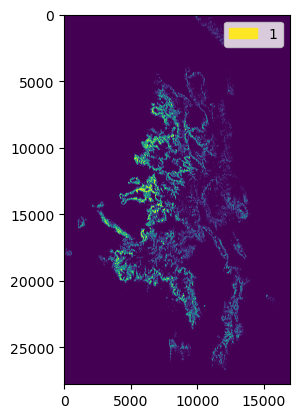

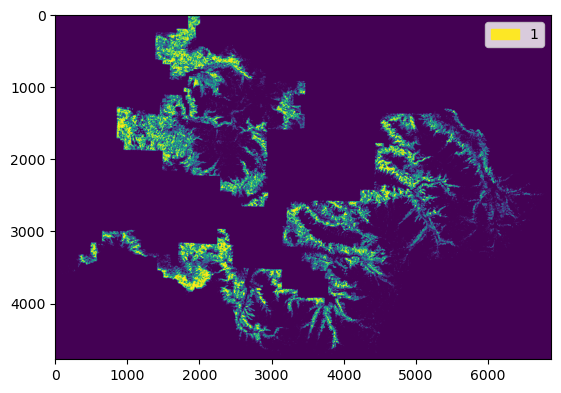

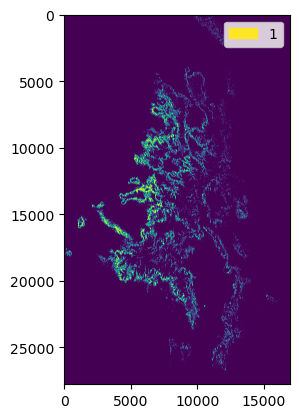

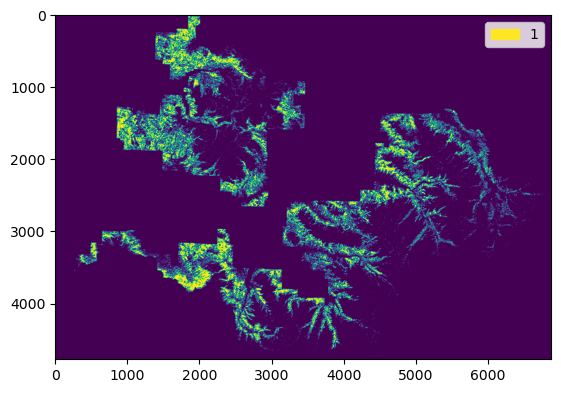

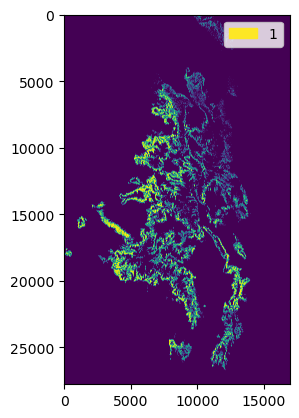

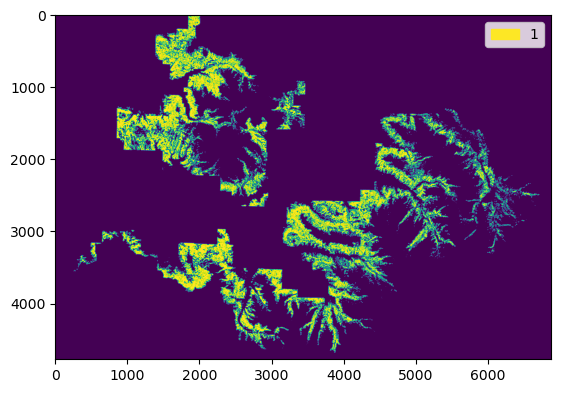

In [3]:
########################################################
# Calculate landscape metrics for the reference images #
########################################################

for ref in ref_paths:
    print(f"Starting for {os.path.basename(ref)}")
    
    ref_img = rxr.open_rasterio(ref, masked=True, cache=False, tiled=True).squeeze()
    ref_img = ref_img.fillna(0).astype(np.uint16)
    print(f"NoData value: {ref_img.rio.nodata}")
    
    regions_ = []
    lss = []  # empty list to store the landscape objects

    for roi in rois:
        print(f"Starting for {os.path.basename(roi)} ...")
        roi = gpd.read_file(roi)
        if roi.crs == ref_img.rio.crs:
            regions_.append(roi)
            print("CRS matches!")
        else: 
            # print(f"CRS of the shape: {roi.crs}; \nRaster: {ref_img.rio.crs}")
            print("Reprojecting to match CRS ...")
            roi = roi.to_crs(proj)
            regions_.append(roi)
            ref_img = ref_img.rio.reproject(proj)
        
        # Clip to the ROI
        print("Clipping")
        clipped = ref_img.rio.clip(roi.geometry)
        
        # Get unique Pixel Values & their Count in numpy array    
        unique, count = np.unique(clipped, return_counts = True)
        print(unique)
        
        # Convert to landscape object
        print("Generating Landscape")
        ls = pls.Landscape(clipped.values, res=(30,30))
        ls.plot_landscape(legend=True)
        lss.append(ls)
        
        # Clean up
        del roi, clipped, ls, unique, count
    
    del ref_img
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    # Export the metrics data frame
    metrics_ = compute_ls_metrics(lss, regions_, source=os.path.basename(ref)[:-4], class_code=1)
    
    del lss, regions_
    
    print(f"Complete for both ROIs and data source: {os.path.basename(ref)}!")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    

## For the 10- and 30-m Classification Results

In [ ]:
####################################################################
# Calculate landscape metrics for the test images (classification) #
####################################################################

for test in test_paths:
    print(f"Starting for {os.path.basename(test)}")
    
    test_img = rxr.open_rasterio(test, masked=True, cache=False, tiled=True).squeeze()
    test_img = test_img.fillna(0).astype(np.uint16)
    print(f"NoData value: {test_img.rio.nodata}")
    
    regions_ = []
    lss = []  # empty list to store the landscape objects

    for roi in rois:
        print(f"Starting for {os.path.basename(roi)} ...")
        roi = gpd.read_file(roi)
        
        if roi.crs == test_img.rio.crs:
            regions_.append(roi)
            print("CRS matches!")
        else: 
            # print(f"CRS of the shape: {roi.crs}; \nRaster: {ref_img.rio.crs}")
            print("Reprojecting to match CRS ...")
            roi = roi.to_crs(proj)
            regions_.append(roi)
            test_img = test_img.rio.reproject(proj)
        
        # Clip to the ROI
        print("Clipping")
        clipped = test_img.rio.clip(roi.geometry)
        
        del test_img
        
        # # Get unique Pixel Values & their Count in numpy array    
        # unique, count = np.unique(clipped, return_counts = True)
        # print(unique)
        
        # Convert to landscape object
        print("Generating Landscape")
        ls = pls.Landscape(clipped.values, res=(30,30))
        ls.plot_landscape(legend=True)
        lss.append(ls)
        
        # Clean up
        del roi, ls, unique, count, clipped
    
    # del test_img
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    # Export the metrics data frame
    metrics_ = compute_ls_metrics(lss, regions_, source=os.path.basename(test)[:-4], class_code=1)
    
    del lss, regions_
    
    print(f"Complete for both ROIs and data source: {os.path.basename(test)}!")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    

In [ ]:
# start_time = time.time()

# for test in test_paths:
#     print(f"Starting for {os.path.basename(ref)}")
#     aspen10m = rxr.open_rasterio(aspen10m_path, masked=True, chache=False, tiled=True).squeeze()
#     print("NoData value:")
#     print(aspen10m.rio.nodata)
#     print(aspen10m.values)

#     lss = []
#     for roi in rois:
#         print(f"Starting for {os.path.basename(roi)} ...")
#         roi = gpd.read_file(roi)
#         if roi.crs == aspen10m.rio.crs:
#             print("CRS matches!")
#         else: 
#             print(f"CRS of the shape: {roi.crs}; \nRaster: {aspen10m.rio.crs}")
#             print("Reprojecting to match CRS ...")
#             roi = roi.to_crs(proj)
#             aspen10m = aspen10m.rio.reproject(proj)
#         # Plot the boundaries
#         f, axx = plt.subplots(1,1)
#         roi.plot(ax=axx)
#         plt.show()
#         # Clip to the ROI
#         print("Clipping")
#         clipped = aspen10m.rio.clip(roi.geometry)
#         # Reclassify to remove values of 0 (background)
#         print("Reclassifying")
#         img = reclassify(clipped, bins=[0,1], new_values=[1,2]).astype(int)
#         print(img.values)
#         # Get unique Pixel Values & their Count in numpy array    
#         unique, count = np.unique(img, return_counts = True)
#         print(unique)
#         print(count)
#         # Convert to landscape object
#         print("Generating Landscape")
#         ls = pls.Landscape(img.values, res=(10,10))
#         ls.plot_landscape(legend=True)
#         lss.append(ls)
#         # Clean up
#         del roi, clipped, img, ls

#     print("Complete!")
#     print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")
#     del aspen10m

In [ ]:
# start_time = time.time()

# # Patch
# print(lss[0].PATCH_METRICS)
# metrics_pch = [
#     'area', 'perimeter', 'perimeter_area_ratio', 'shape_index'
# ]

# stats=[]
# for i in range(len(lss)):
#     ls_ = lss[i]
#     name = os.path.basename(rois[i])[:-5]
#     print(f"Computing patch metrics for the {name} landscape ...")
#     # Compute the aspen class metrics 
#     patch_mets = ls_.compute_patch_metrics_df(metrics=metrics_pch)
#     patch_mets = patch_mets[patch_mets['class_val'] == 2]
#     stats.append(patch_mets)
#     patch_mets.info()
#     print(pd.DataFrame(patch_mets.head()))
#     patch_mets.to_csv(os.path.join(maindir,f'aspen-fire/Aim1/data/tabular/mod/{name}_patch_metrics.csv'))
#     print("Successfully exported patch metrics table!")
#     print("Computing class metrics ...")
#     # Clean up a bit
#     del ls_, patch_mets

# print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")
# del lss  # clean up the old landscapes

## Compute Patch & Landscape Metrics for the 30m Reclass (max)

In [ ]:
# start_time = time.time()

# aspen30m = rxr.open_rasterio(aspen30m_path, masked=True, chache=False, tiled=True).squeeze()
# print("NoData value:")
# print(aspen30m.rio.nodata)
# print(aspen30m.values)

# lss = []
# for roi in rois:
#     print(f"Starting for {os.path.basename(roi)} ...")
#     roi = gpd.read_file(roi)
#     if roi.crs == aspen30m.rio.crs:
#         print("CRS matches!")
#     else: 
#         print(f"CRS of the shape: {roi.crs}; \nRaster: {aspen30m.rio.crs}")
#         print("Reprojecting to match CRS ...")
#         roi = roi.to_crs(proj)
#         aspen30m = aspen30m.rio.reproject(proj)
#     # Plot the boundaries
#     f, axx = plt.subplots(1,1)
#     roi.plot(ax=axx)
#     plt.show()
#     # Clip to the ROI
#     print("Clipping")
#     clipped = aspen30m.rio.clip(roi.geometry)
#     # Reclassify to remove values of 0 (background)
#     print("Reclassifying")
#     img = reclassify(clipped, bins=[0,1], new_values=[1,2]).astype(int)
#     print(img.values)
#     # Get unique Pixel Values & their Count in numpy array    
#     unique, count = np.unique(img, return_counts = True)
#     print(unique)
#     print(count)
#     # Convert to landscape object
#     print("Generating Landscape")
#     ls = pls.Landscape(img.values, res=(30,30))
#     ls.plot_landscape(legend=True)
#     lss.append(ls)
#     # Clean up
#     del roi, clipped, img, ls
    
# print("Complete!")
# print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")
# del aspen30m

In [ ]:
# import time
# start_time = time.time()

# patch_stats=[]
# class_stats = []
# names = ['SRME','WRNF']
# for i in range(len(lss)):
#     ls_ = lss[i]
#     name = names[i]
    
#     # Compute the aspen patch metrics 
#     print(f"Computing patch metrics for the {name} landscape ...")

#     area = pd.DataFrame(ls_.area(class_val=2, hectares=True)).reset_index()  # patch area
#     print(area.head())
#     print(area.max())
    
#     perimeter = pd.DataFrame(ls_.perimeter(class_val=2) ).reset_index() # perimeter length    
#     perimeter_ar_r = pd.DataFrame(ls_.perimeter_area_ratio(class_val=2, hectares=True)).reset_index()
#     shp_i = pd.DataFrame(ls_.shape_index(class_val=2)).reset_index()
    
#     patch_df = pd.merge(area, perimeter, on="index")
#     patch_df = pd.merge(patch_df, perimeter_ar_r, on="index")
#     patch_df = pd.merge(patch_df, shp_i, on="index")
#     patch_df['region'] = name
#     print(patch_df.head())
    
#     patch_stats.append(patch_df)
    
#     patch_df.to_csv(os.path.join(maindir,f'data/tabular/mod/{name}_patch_metrics_aspen30m.csv'))
#     print("Successfully exported patch metrics table!")
    
#     # Class and landscape-level metrics
#     print("Computing class-level metrics ...")
    
#     tot_ar = ls_.total_area(class_val=2, hectares=True)
#     prop = ls_.proportion_of_landscape(class_val=2, percent=True)
#     n_ptchs = ls_.number_of_patches(class_val=2)
#     ptch_den = ls_.patch_density(class_val=2, percent=True, hectares=True)
    
#     class_df = pd.DataFrame(
#         {'total_area': [tot_ar],
#          'prop_area': [prop],
#          'n_patch': [n_ptchs],
#          'patch_den': [ptch_den]
#         }
#     )
#     print(class_df)
    
#     class_stats.append(class_df)
    
#     class_df.to_csv(os.path.join(maindir,f'data/tabular/mod/{name}_class_metrics_aspen30m.csv'))
#     print("Successfully exported class metrics table!")
    
#     # Clean up a bit
#     del ls_

# class_metrics = pd.concat(class_stats, axis=0)
# patch_metrics = pd.concat(patch_stats, axis=0)

# class_metrics.to_csv(os.path.join(maindir,f'data/tabular/mod/class_metrics_aspen30m.csv'))
# patch_metrics.to_csv(os.path.join(maindir,f'data/tabular/mod/patch_metrics_aspen30m.csv'))

# print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.")